In [7]:
# 基于Fashion-MNIST数据集，使用LightGBM模型实现监督学习中的多分类任务，研究不同数据规模与不同模型参数对LightGBM多分类模型性能的影响
# Fashion-MNIST数据集中类别标签0-9分别代表如下内容：
# 0：t-shirt（T恤），1：trouser（牛仔裤），2：pullover（套衫），3：dress（裙子），4：coat（外套）
# 5：sandal（凉鞋），6：shirt（衬衫），7：sneaker（运动鞋），8：bag（包），9：ankle boot（短靴）

# Fashion-MNIST数据集下载地址：https://github.com/zalandoresearch/fashion-mnist，目录为data/fashion
# 从Github上下载Fashion-MNIST数据集后，将所有.gz文件解压到任意指定文件夹，保存路径
# 即train-images-idx3-ubyte、t10k-images-idx3-ubyte、train-labels-idx1-ubyte、t10k-labels-idx1-ubyte

#本代码LightGBM原始参数设置如下（非默认）：
#objective='multiclass',
#num_class=10, 
#class_weight='balanced', #类的权重=类频率的反比
#learning_rate=0.05,
#n_estimators=200,
#max_depth=15,
#num_leaves=3000,
#max_bin=400, 
#min_data_in_leaf=21,#20
#bagging_fraction=0.9, 
#bagging_freq=5,        #默认0，禁用bagging
#feature_fraction=0.8,
#reg_alpha=0.01, 
#reg_lambda=0.3,
#min_split_gain=0.1,
#n_jobs=15
#对模型做出调整时将基于以上参数设置进行调整

import pandas as pd
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler #标准化
import numpy as np
from sklearn.metrics import confusion_matrix
from timeit import default_timer as timer
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score  
import joblib
from imblearn.over_sampling import SMOTE #过抽样处理库SMOTE
from collections import Counter
from sklearn.metrics import f1_score

tic = timer()   #start time

def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np
    labels_path = os.path.join(path,'%s-labels-idx1-ubyte'% kind)
    images_path = os.path.join(path,'%s-images-idx3-ubyte'% kind)
    with open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)
    with open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)
    return images, labels
 
data_dir = "C:/Users/1/Desktop"#此处为解压后的数据集的保存路径
 
X_train, y_train = load_mnist(data_dir, kind='train')#训练集数据
X_test, y_test = load_mnist(data_dir, kind='t10k')#测试集数据

#训练集洗牌
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

#测试集洗牌
shuffle_index = np.random.permutation(10000)
X_test, y_test = X_test[shuffle_index], y_test[shuffle_index]

#更改训练集数据规模
#X_train, y_train = X_train[0:48000], y_train[0:48000]
#X_train, y_train = X_train[0:36000], y_train[0:36000]
#X_train, y_train = X_train[0:24000], y_train[0:24000]
#X_train, y_train = X_train[0:12000], y_train[0:12000]
#X_train, y_train = X_train[0:2000], y_train[0:2000]

#更改测试集数据规模
#X_test, y_test = X_test[0:8000], y_test[0:8000]
#X_test, y_test = X_test[0:6000], y_test[0:6000]
#X_test, y_test = X_test[0:4000], y_test[0:4000]
#X_test, y_test = X_test[0:2000], y_test[0:2000]
#X_test, y_test = X_test[0:500], y_test[0:500]

#将训练集不平衡化
#for i in range(len(y_train)//2):
#    if y_train[i] < 6:
#        y_train = np.delete(y_train,[i])
#        X_train = np.delete(X_train,[i],0)

#将测试集不平衡化
#for i in range(len(y_test)//2):
#    if y_test[i] < 4:
#        y_test = np.delete(y_test,[i])
#        X_test = np.delete(X_test,[i],0)
        
#标准化
std = StandardScaler()
std.fit(X_train)
X_train_std=std.transform(X_train) 
#用训练集的均值和方差标准化测试集
X_test_std=std.transform(X_test)

#sklearn lgb接口
#更改模型参数时将基于开头给出的原始参数为基准进行调参
gbm = lgb.LGBMClassifier(objective='multiclass',
                        num_class=10, 
                        class_weight='balanced', #类的权重=类频率的反比
                        learning_rate=0.05,
                        n_estimators=200,
                        max_depth=15,
                        num_leaves=3000,
                        max_bin=400, 
                        min_data_in_leaf=21,#20
                        bagging_fraction=0.8, 
                        bagging_freq=5,        #默认0，禁用bagging
                        feature_fraction=0.8,
                        reg_alpha=0.01, 
                        reg_lambda=0.3,
                        min_split_gain=0.1,
                        n_jobs=15
                        )

gbm.fit(X_train_std,y_train)

y_train_pred=gbm.predict(X_train_std)

#计算准确率
#训练集
train_accuracy = accuracy_score(y_train,y_train_pred)
print('train accuarcy:%.2f%%'%(train_accuracy*100))

y_pred_prob=gbm.predict_proba(X_test_std)#按左到右输出：类别0，1，2，3，4，5，6，7，8，9的概率
y_pred=gbm.predict(X_test_std)
# print(y_pred)
# print(y_pred_prob.shape)
# print(y_pred_prob)
# lyf=np.argmax(y_pred_prob,axis=1)
# print(lyf)
# print((y_pred==lyf).all())#true
 

#计算准确率
#测试集
accuracy = accuracy_score(y_test,y_pred)
print('test accuarcy:%.2f%%'%(accuracy*100))

print("total test samples:%d"%len(y_test))
print("confusion matrix:")
results=confusion_matrix(y_test,y_pred, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
print(results)


h=results.shape[1]
 
#评价指标：TS score=Na/(Na+Nb+Nc)
print("TS score:")
for k in range(h):
    Nb=0 #predict in,actual not in
    Nc=0 #predict noy in,actual in
    Na=float(results[k,k])
    for y_t,y_p in zip(y_test,y_pred):
        if y_t!=k and y_p==k:
            Nb+=1

        if y_t==k and y_p!=k:
            Nc+=1
    
    ts_score=Na/(Na+Nb+Nc)

    print("class %d : %.2f"%(k,ts_score))

print(classification_report(y_test,y_pred,target_names=['0','1','2','3','4','5','6','7','8','9']))

toc = timer()    #end time
print("Finish,total time: %d s"%(toc - tic))#运行时间

score = f1_score(y_test, y_pred, average='macro')
print(score)#F1-score


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
train accuarcy:100.00%
test accuarcy:89.96%
total test samples:10000
confusion matrix:
[[879   0  12  20   4   1  81   0   3   0]
 [  1 974   1  15   5   0   2   0   2   0]
 [ 15   0 845   9  78   0  50   0   3   0]
 [ 14   4  10 923  24   0  23   0   2   0]
 [  0   0  85  26 845   0  43   0   1   0]
 [  0   0   1   0   0 970   0  18   0  11]
 [135   1 102  24  72   0 654   0  12   0]
 [  0   0   0   0   0   4   0 972   0  24]
 [  0   1   2   3   3   1   9   4 977   0]
 [  0   0   0   0   0   5   0  37   1 957]]
TS score:
c

(60000, 784)
(60000,)
(10000, 784)
(10000,)
0


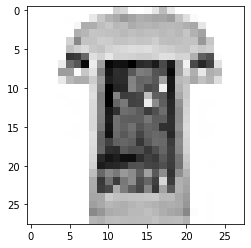

In [8]:
#本部分为一些测试或验证代码，目的是验证以上模型的正确性以及数据集处理的正确性
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = np.array(X_train[50])
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary,interpolation="nearest")
print(y_train[50])